In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import numpy as np

# Helper function to initialize model weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Central configuration for the project
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 2
    dataset_path = '/kaggle/input/dgm-animals/Animals_data/animals/animals'
    image_size = 128
    img_channels = 3
    latent_dim = 100
    embedding_dim = 100
    features_g = 64
    features_d = 64
    batch_size = 64
    num_epochs = 100
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    label_smoothing = 0.1
    output_dir = '/kaggle/working/cgan_final_results'
    sample_interval = 10
    checkpoint_interval = 20

# Instantiate and set up
config = Config()
os.makedirs(config.output_dir, exist_ok=True)
print(f"Configuration complete. Using device: {config.device}")

Configuration complete. Using device: cuda


In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, channels_img, features_g):
        super(ConditionalGenerator, self).__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            self._block(latent_dim + embedding_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(True))
    def forward(self, z, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, embedding], dim=1)
        return self.net(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, channels_img, features_d):
        super(ConditionalDiscriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            # Input: (N, C, 128, 128)
            nn.Conv2d(channels_img + embedding_dim, features_d, kernel_size=4, stride=2, padding=1), # -> 64x64
            nn.LeakyReLU(0.2, inplace=True),

            self._block(features_d, features_d * 2, 4, 2, 1), # -> 32x32
            self._block(features_d * 2, features_d * 4, 4, 2, 1), # -> 16x16
            self._block(features_d * 4, features_d * 8, 4, 2, 1), # -> 8x8
            
            # --- ADDED THIS BLOCK to downsample from 8x8 to 4x4 ---
            self._block(features_d * 8, features_d * 16, 4, 2, 1), # -> 4x4
            
            # Final convolution to get a 1x1 output
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=1, padding=0), # -> 1x1
            
            nn.Sigmoid() # Output a probability
        )
        
    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        
    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, embedding], dim=1)
        # The .view().squeeze() will now correctly produce a [batch_size] output
        return self.net(x).view(-1, 1).squeeze(1)

print("Model architectures defined.")

Model architectures defined.


In [3]:
# --- Data Loading ---
transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(root=config.dataset_path, transform=transform)
config.num_classes = len(dataset.classes)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
print(f"Dataset loaded with {len(dataset)} images in {config.num_classes} classes.")

# --- Initialization ---
gen = ConditionalGenerator(config.latent_dim, config.num_classes, config.embedding_dim, config.img_channels, config.features_g).to(config.device)
disc = ConditionalDiscriminator(config.num_classes, config.embedding_dim, config.img_channels, config.features_d).to(config.device)
gen.apply(weights_init)
disc.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(disc.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))
optimizerG = optim.Adam(gen.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))

# --- Checkpoint Loading ---
start_epoch = 0
G_losses, D_losses, D_x_history, D_G_z_history = [], [], [], []
checkpoint_path = os.path.join(config.output_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    print("Loading from checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    G_losses, D_losses, D_x_history, D_G_z_history = checkpoint['metrics']
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting from scratch.")

# --- Training Loop ---
print("Starting training...")
fixed_noise = torch.randn(64, config.latent_dim, 1, 1, device=config.device)
fixed_labels = torch.randint(0, config.num_classes, (64,), device=config.device)

for epoch in range(start_epoch, config.num_epochs):
    epoch_loss_d, epoch_loss_g, epoch_d_x, epoch_d_gz = 0.0, 0.0, 0.0, 0.0
    
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs, labels = real_imgs.to(config.device), labels.to(config.device)
        b_size = real_imgs.size(0)
        real_label = torch.full((b_size,), 1.0 - config.label_smoothing, device=config.device)
        fake_label = torch.full((b_size,), 0.0, device=config.device)
        
        # Train Discriminator
        disc.zero_grad()
        output_real = disc(real_imgs, labels)
        lossD_real = criterion(output_real, real_label)
        epoch_d_x += output_real.mean().item()
        
        noise = torch.randn(b_size, config.latent_dim, 1, 1, device=config.device)
        fake_imgs = gen(noise, labels)
        output_fake = disc(fake_imgs.detach(), labels)
        lossD_fake = criterion(output_fake, fake_label)
        epoch_d_gz += output_fake.mean().item()
        
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        optimizerD.step()

        # Train Generator
        gen.zero_grad()
        output_gen = disc(fake_imgs, labels)
        lossG = criterion(output_gen, real_label)
        lossG.backward()
        optimizerG.step()
        
        epoch_loss_d += lossD.item()
        epoch_loss_g += lossG.item()
    
    # Log and save metrics
    num_batches = len(dataloader)
    G_losses.append(epoch_loss_g / num_batches)
    D_losses.append(epoch_loss_d / num_batches)
    D_x_history.append(epoch_d_x / num_batches)
    D_G_z_history.append(epoch_d_gz / num_batches)

    print(f"[{epoch+1}/{config.num_epochs}] Loss_D: {D_losses[-1]:.4f} | Loss_G: {G_losses[-1]:.4f} | D(x): {D_x_history[-1]:.4f} | D(G(z)): {D_G_z_history[-1]:.4f}")

    # Save sample images and checkpoint
    if (epoch + 1) % config.sample_interval == 0:
        with torch.no_grad():
            gen.eval()
            samples = gen(fixed_noise, fixed_labels).detach().cpu()
            save_image(samples, os.path.join(config.output_dir, f"samples_epoch_{epoch+1:03d}.png"), normalize=True)
            gen.train()
    if (epoch + 1) % config.checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'disc_state_dict': disc.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'metrics': (G_losses, D_losses, D_x_history, D_G_z_history),
        }, checkpoint_path)
        print(f"*** Checkpoint saved at epoch {epoch+1} ***")

print("Training finished.")

# --- Save Final Models ---
torch.save(gen.state_dict(), os.path.join(config.output_dir, 'generator_final.pth'))
torch.save(disc.state_dict(), os.path.join(config.output_dir, 'discriminator_final.pth'))

Dataset loaded with 5376 images in 90 classes.
No checkpoint found. Starting from scratch.
Starting training...
[1/100] Loss_D: 1.1599 | Loss_G: 1.1448 | D(x): 0.4179 | D(G(z)): 0.4825
[2/100] Loss_D: 0.9523 | Loss_G: 0.9834 | D(x): 0.4325 | D(G(z)): 0.4702
[3/100] Loss_D: 0.8411 | Loss_G: 0.9051 | D(x): 0.4409 | D(G(z)): 0.4610
[4/100] Loss_D: 0.8489 | Loss_G: 0.8886 | D(x): 0.4457 | D(G(z)): 0.4620
[5/100] Loss_D: 0.8255 | Loss_G: 0.8751 | D(x): 0.4488 | D(G(z)): 0.4553
[6/100] Loss_D: 0.7859 | Loss_G: 0.8557 | D(x): 0.4463 | D(G(z)): 0.4533
[7/100] Loss_D: 0.8397 | Loss_G: 0.8656 | D(x): 0.4469 | D(G(z)): 0.4545
[8/100] Loss_D: 0.7836 | Loss_G: 0.8641 | D(x): 0.4517 | D(G(z)): 0.4552
[9/100] Loss_D: 0.7940 | Loss_G: 0.8629 | D(x): 0.4486 | D(G(z)): 0.4485
[10/100] Loss_D: 0.7783 | Loss_G: 0.8630 | D(x): 0.4494 | D(G(z)): 0.4537
[11/100] Loss_D: 0.7771 | Loss_G: 0.8760 | D(x): 0.4497 | D(G(z)): 0.4532
[12/100] Loss_D: 0.7760 | Loss_G: 0.8818 | D(x): 0.4473 | D(G(z)): 0.4502
[13/100] 

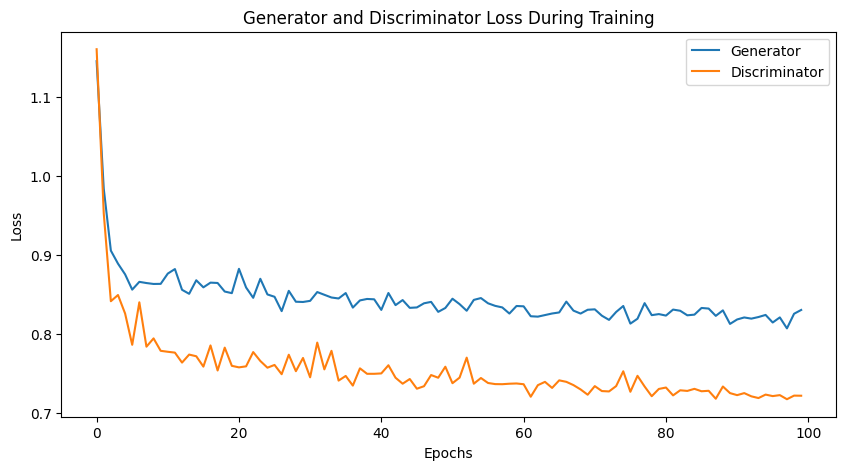

In [4]:
# --- Plot Loss Curves ---
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(config.output_dir, "loss_curve.png"))
plt.show()

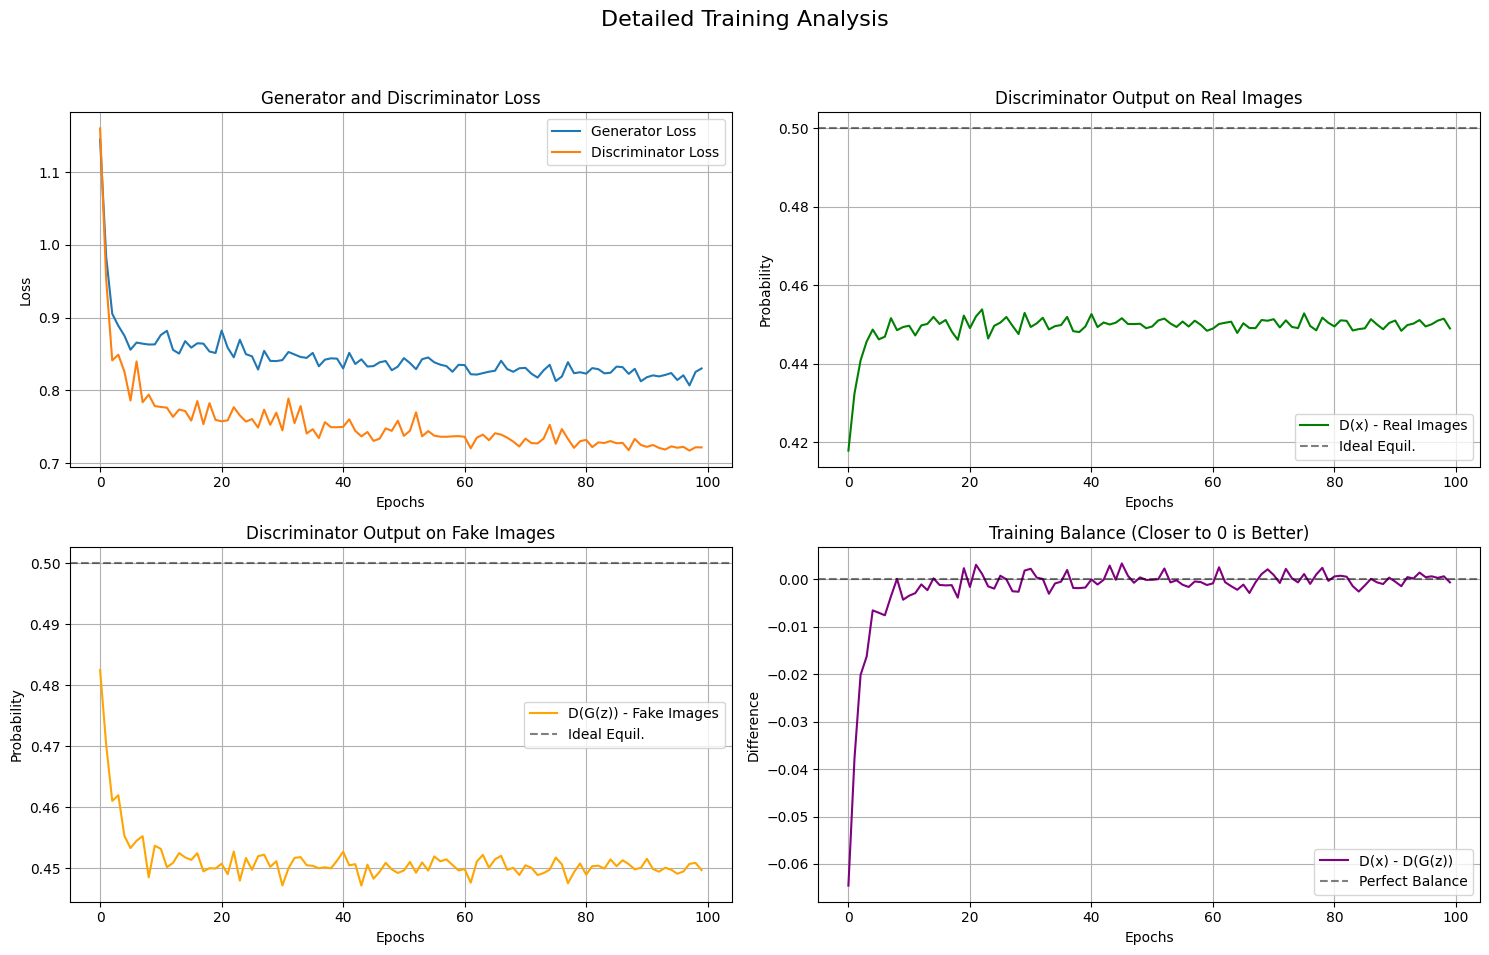

In [5]:
# --- Enhanced Plotting ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Detailed Training Analysis", fontsize=16)

# Loss curves
ax1.plot(G_losses, label="Generator Loss")
ax1.plot(D_losses, label="Discriminator Loss")
ax1.set_title("Generator and Discriminator Loss")
ax1.set_xlabel("Epochs"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)

# D(x)
ax2.plot(D_x_history, label="D(x) - Real Images", color='green')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Ideal Equil.')
ax2.set_title("Discriminator Output on Real Images")
ax2.set_xlabel("Epochs"); ax2.set_ylabel("Probability"); ax2.legend(); ax2.grid(True)

# D(G(z))
ax3.plot(D_G_z_history, label="D(G(z)) - Fake Images", color='orange')
ax3.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Ideal Equil.')
ax3.set_title("Discriminator Output on Fake Images")
ax3.set_xlabel("Epochs"); ax3.set_ylabel("Probability"); ax3.legend(); ax3.grid(True)

# Training balance
balance = np.array(D_x_history) - np.array(D_G_z_history)
ax4.plot(balance, label="D(x) - D(G(z))", color='purple')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')
ax4.set_title("Training Balance (Closer to 0 is Better)")
ax4.set_xlabel("Epochs"); ax4.set_ylabel("Difference"); ax4.legend(); ax4.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(config.output_dir, 'training_analysis.png'))
plt.show()

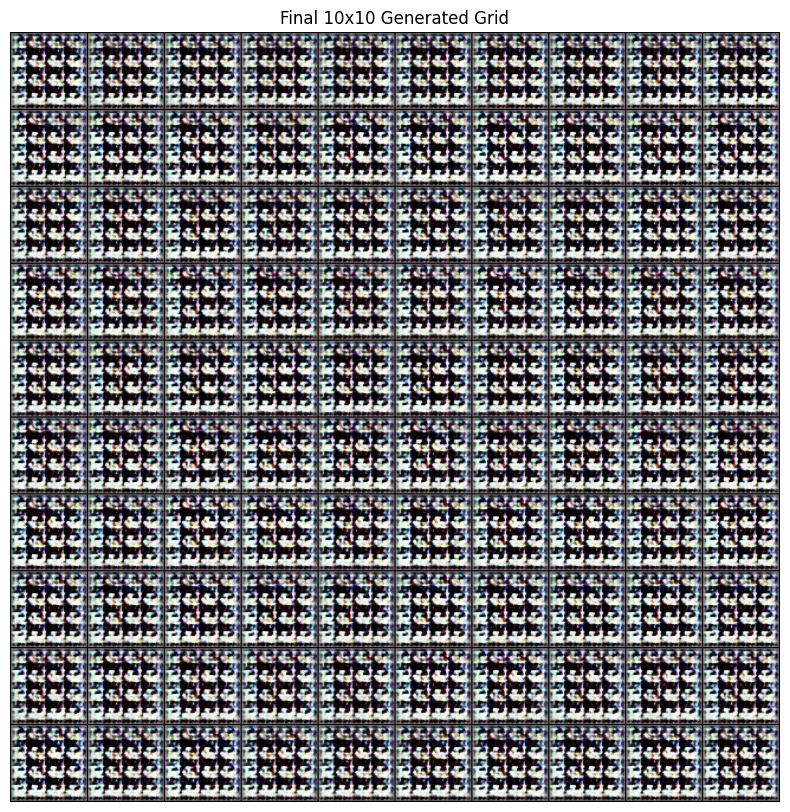

10x10 grid generated and saved successfully.


In [6]:
# --- Load Trained Generator ---
# Ensure the Config class from Cell 1 is available
# Ensure the ConditionalGenerator class from Cell 2 is available
gen_final = ConditionalGenerator(config.latent_dim, config.num_classes, config.embedding_dim, config.img_channels, config.features_g).to(config.device)
gen_final.load_state_dict(torch.load(os.path.join(config.output_dir, 'generator_final.pth')))
gen_final.eval()

# --- Generate 10x10 Grid ---
# Create 100 noise vectors and corresponding labels (10 images each from 10 classes)
grid_labels = torch.arange(10).repeat_interleave(10).to(config.device)
grid_noise = torch.randn(100, config.latent_dim, 1, 1, device=config.device)

with torch.no_grad():
    generated_grid = gen_final(grid_noise, grid_labels).detach().cpu()

# --- Save and Display Grid ---
grid_img = make_grid(generated_grid, nrow=10, normalize=True)
save_image(grid_img, os.path.join(config.output_dir, "final_10x10_grid.png"))

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid_img, (1, 2, 0)))
plt.axis("off")
plt.title("Final 10x10 Generated Grid")
plt.show()

print("10x10 grid generated and saved successfully.")